In [282]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import cv2
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [283]:
def read_data(path):
    
    train_path = path+"/train"
    test_path = path+"/test"
    validation_path = path+"/val"
    
    tr_data, test_data, val_data = [], [], []
    tr_out, test_out, val_out = [], [], []
    labels=[]
    for i in os.listdir(train_path):
        labels.append(int(i))

        if i != ".DS_Store":
            for j in os.listdir(train_path+"/"+i):
                tr_data.append(cv2.imread(train_path+"/"+i+"/"+j, cv2.IMREAD_GRAYSCALE))
                tr_out.append(i)

            for j in os.listdir(test_path+"/"+i):
                test_data.append(cv2.imread(test_path+"/"+i+"/"+j, cv2.IMREAD_GRAYSCALE))
                test_out.append(i)

            for j in os.listdir(validation_path+"/"+i):
                val_data.append(cv2.imread(validation_path+"/"+i+"/"+j, cv2.IMREAD_GRAYSCALE))
                val_out.append(i)
                
                
    tr_data, test_data, val_data = np.array(tr_data), np.array(test_data), np.array(val_data)
    tr_out, test_out, val_out = np.array(list(map(int, tr_out))), np.array(list(map(int, test_out))), np.array(list(map(int, val_out)))

    return tr_data, test_data, val_data, tr_out, test_out, val_out, labels

In [284]:
path = "/home/urvashi/Downloads/Group_5"
tr_data, test_data, val_data, tr_out, test_out, val_out,labels = read_data(path)
labels.sort()

In [285]:
def convert_labels(d):
    op=d
    for i in range(len(d)):
        if op[i] == 4:
            op[i]=3
        elif op[i] == 7:
            op[i]=4
    return op

In [286]:
train_out=convert_labels(tr_out)
val_out=convert_labels(val_out)
test_out=convert_labels(test_out)

In [287]:
train_data = tr_data.reshape(tr_data.shape[0],784)
val_data = val_data.reshape(val_data.shape[0],784)
test_data = test_data.reshape(test_data.shape[0],784)
train_mean = np.mean(train_data, axis=0)

In [288]:
def PCA(X_train,X_val,X_test,mean,n_components):    
    
    X_mean = mean
    X_train_centered = X_train - X_mean
    X_val_centered = X_val - X_mean
    X_test_centered = X_test - X_mean

    cov_matrix = np.cov(X_train_centered.T)

    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Sort the eigenvectors in descending order of eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Project the data onto the eigenvectors to obtain the principal components
    X_train_pca = X_train_centered.dot(eigenvectors[:, :n_components])
    X_val_pca = X_val_centered.dot(eigenvectors[:, :n_components])
    X_test_pca = X_test_centered.dot(eigenvectors[:, :n_components])

    X_train_reconstructed = np.dot(X_train_pca, eigenvectors[:, :n_components].T) + X_mean
    
    rand = [8363, 9141, 3437,  6127, 118] # random list of index for random images 
    fig, axs = plt.subplots(2, 5, figsize=(10, 2))    
    
    for i in range(5):
        axs[0, i].imshow(X_train[rand[i]].reshape(28, 28)) # orignal image
        axs[0, i].axis('off')
        
        axs[1, i].imshow(X_train_reconstructed[rand[i]].reshape(28, 28)) # reconstructed image
        axs[1, i].axis('off')

    plt.show()
    return X_train_pca , X_val_pca ,X_test_pca

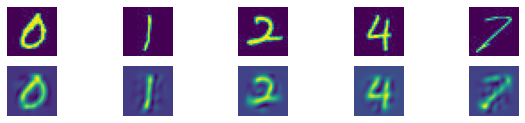

In [289]:
train_32, val_32,test_32 = PCA(train_data,val_data,test_data,train_mean,32)

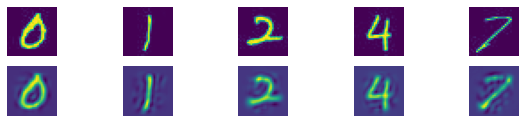

In [290]:
train_64, val_64 ,test_64 = PCA(train_data,val_data,test_data,train_mean,64)

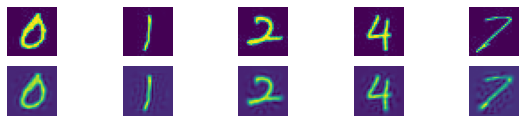

In [291]:
train_128, val_128 ,test_128 = PCA(train_data,val_data,test_data,train_mean,128)

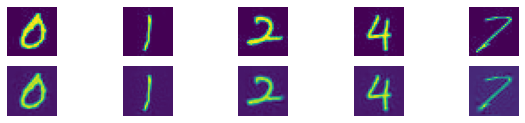

In [292]:
train_256, val_256 ,test_256 = PCA(train_data,val_data,test_data,train_mean,256)

# Architecture 1

## 32 Dimension Representation

In [348]:
# Generating Three Layer FCNN Architecture
model32 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32,), name='Input_Layer'),    
    tf.keras.layers.Dense(512, activation='sigmoid', name='Hidden_Layer_1'),
    tf.keras.layers.Dense(256, activation='sigmoid', name='Hidden_Layer_2'),
    tf.keras.layers.Dense(256, activation='sigmoid', name='Hidden_Layer_3'),
    tf.keras.layers.Dense(5, activation='softmax', name='Output_Layer')
])

# Printing the architecture details of the model
model32.summary()

# saving model weights
model32.save_weights("/home/urvashi/Downloads/Group_5/weights_a1.h5")

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (Dense)      (None, 512)               16896     
                                                                 
 Hidden_Layer_2 (Dense)      (None, 256)               131328    
                                                                 
 Hidden_Layer_3 (Dense)      (None, 256)               65792     
                                                                 
 Output_Layer (Dense)        (None, 5)                 1285      
                                                                 
Total params: 215,301
Trainable params: 215,301
Non-trainable params: 0
_________________________________________________________________


In [294]:
#Setting the optimizer and compiling
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, name='Adam')
model32.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',    metrics=['accuracy'])

# Setting the convergence criteria and fitting the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,patience=2)
trained32 = model32.fit(train_32, train_out, epochs=10000, callbacks=callback)

Epoch 1/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.2360 - accuracy: 0.9346
Epoch 2/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0811 - accuracy: 0.9761
Epoch 3/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0565 - accuracy: 0.9825
Epoch 4/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0464 - accuracy: 0.9849
Epoch 5/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0365 - accuracy: 0.9880
Epoch 6/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0287 - accuracy: 0.9900
Epoch 7/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0253 - accuracy: 0.9913
Epoch 8/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0241 - accuracy: 0.9917
Epoch 9/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0202 - accuracy: 0.9936
Epoch 10/10000
356/356 [==============================] - 1s 2ms/step - l

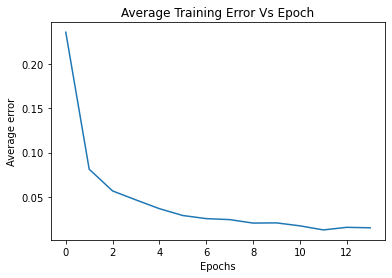

In [295]:
#Plotting error vs epoch graph
plt.plot(trained32.history['loss'])
plt.title("Average Training Error Vs Epoch")
plt.xlabel("Epochs")
plt.ylabel("Average error")
plt.savefig("/home/urvashi/Downloads/Group_5/model32.png")
plt.show()

In [296]:
loss, mse = model32.evaluate(val_32, val_out)

119/119 [==============================] - 0s 1ms/step - loss: 0.0610 - accuracy: 0.9850


In [297]:
loss, mse = model32.evaluate(test_32, test_out)

119/119 [==============================] - 0s 1ms/step - loss: 0.0734 - accuracy: 0.9826


119/119 [==============================] - 0s 985us/step


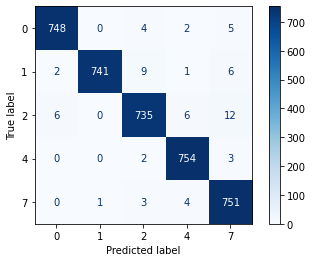

In [298]:
predictions = model32.predict(test_32, verbose=1)
p_class = np.argmax(predictions, axis=1)
cm = confusion_matrix(test_out, p_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("/home/urvashi/Downloads/Group_5/cm_32.png")
plt.show()

## 64 Dimension Representation

In [299]:
# Generating Three Layer FCNN Architecture
model64 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(64,), name='Input_Layer'),    
    tf.keras.layers.Dense(512, activation='sigmoid', name='Hidden_Layer_1'),
    tf.keras.layers.Dense(256, activation='sigmoid', name='Hidden_Layer_2'),
    tf.keras.layers.Dense(256, activation='sigmoid', name='Hidden_Layer_3'),
    tf.keras.layers.Dense(5, activation='softmax', name='Output_Layer')
])

# Printing the architecture details of the model
model64.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (Dense)      (None, 512)               33280     
                                                                 
 Hidden_Layer_2 (Dense)      (None, 256)               131328    
                                                                 
 Hidden_Layer_3 (Dense)      (None, 256)               65792     
                                                                 
 Output_Layer (Dense)        (None, 5)                 1285      
                                                                 
Total params: 231,685
Trainable params: 231,685
Non-trainable params: 0
_________________________________________________________________


In [300]:
#Setting the optimizer and compiling
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, name='Adam')
model64.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',    metrics=['accuracy'])

# Setting the convergence criteria and fitting the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,patience=2)
trained64 = model64.fit(train_64, train_out, epochs=10000, callbacks=callback)

Epoch 1/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.2280 - accuracy: 0.9365
Epoch 2/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0760 - accuracy: 0.9775
Epoch 3/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0570 - accuracy: 0.9820
Epoch 4/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0436 - accuracy: 0.9851
Epoch 5/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0373 - accuracy: 0.9882
Epoch 6/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0297 - accuracy: 0.9907
Epoch 7/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0206 - accuracy: 0.9935
Epoch 8/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0170 - accuracy: 0.9946
Epoch 9/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0153 - accuracy: 0.9950
Epoch 10/10000
356/356 [==============================] - 1s 2ms/step - l

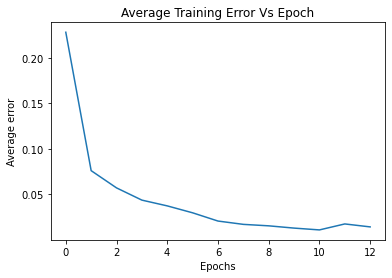

In [301]:
#Plotting error vs epoch graph
plt.plot(trained64.history['loss'])
plt.title("Average Training Error Vs Epoch")
plt.xlabel("Epochs")
plt.ylabel("Average error")
plt.savefig("/home/urvashi/Downloads/Group_5/model64.png")
plt.show()

In [302]:
loss, mse = model64.evaluate(val_64, val_out)

119/119 [==============================] - 0s 1ms/step - loss: 0.0635 - accuracy: 0.9860


In [303]:
loss, mse = model64.evaluate(val_64, val_out)

119/119 [==============================] - 0s 1ms/step - loss: 0.0635 - accuracy: 0.9860


119/119 [==============================] - 0s 1ms/step


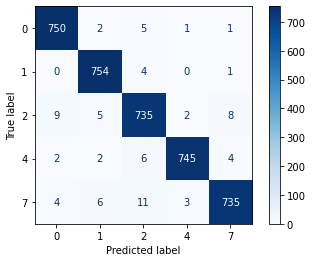

In [304]:
predictions = model64.predict(test_64, verbose=1)
p_class = np.argmax(predictions, axis=1)
cm = confusion_matrix(test_out, p_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("/home/urvashi/Downloads/Group_5/cm_64.png")
plt.show()

## 128 Dimension Representation

In [305]:
# Generating Three Layer FCNN Architecture
model128 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(128,), name='Input_Layer'),    
    tf.keras.layers.Dense(512, activation='sigmoid', name='Hidden_Layer_1'),
    tf.keras.layers.Dense(256, activation='sigmoid', name='Hidden_Layer_2'),
    tf.keras.layers.Dense(256, activation='sigmoid', name='Hidden_Layer_3'),
    tf.keras.layers.Dense(5, activation='softmax', name='Output_Layer')
])

# Printing the architecture details of the model
model128.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (Dense)      (None, 512)               66048     
                                                                 
 Hidden_Layer_2 (Dense)      (None, 256)               131328    
                                                                 
 Hidden_Layer_3 (Dense)      (None, 256)               65792     
                                                                 
 Output_Layer (Dense)        (None, 5)                 1285      
                                                                 
Total params: 264,453
Trainable params: 264,453
Non-trainable params: 0
_________________________________________________________________


In [306]:
#Setting the optimizer and compiling
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, name='Adam')
model128.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',    metrics=['accuracy'])

# Setting the convergence criteria and fitting the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,patience=1)
trained128 = model128.fit(train_128, train_out, epochs=10000, callbacks=callback)

Epoch 1/10000
356/356 [==============================] - 2s 3ms/step - loss: 0.2252 - accuracy: 0.9372
Epoch 2/10000
356/356 [==============================] - 1s 3ms/step - loss: 0.0724 - accuracy: 0.9791
Epoch 3/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0503 - accuracy: 0.9840
Epoch 4/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0357 - accuracy: 0.9887
Epoch 5/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0326 - accuracy: 0.9906
Epoch 6/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0261 - accuracy: 0.9918
Epoch 7/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0244 - accuracy: 0.9915
Epoch 8/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0173 - accuracy: 0.9947
Epoch 9/10000
356/356 [==============================] - 1s 2ms/step - loss: 0.0150 - accuracy: 0.9952
Epoch 10/10000
356/356 [==============================] - 1s 3ms/step - l

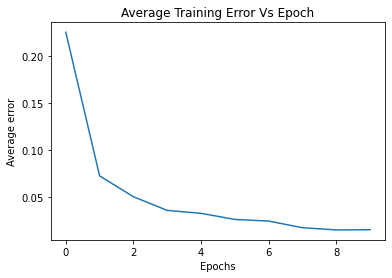

In [344]:
#Plotting error vs epoch graph
plt.plot(trained128.history['loss'])
plt.title("Average Training Error Vs Epoch")
plt.xlabel("Epochs")
plt.ylabel("Average error")
plt.savefig("/home/urvashi/Downloads/Group_5/model128.png")
plt.show()

In [308]:
loss, mse = model128.evaluate(val_128, val_out)

119/119 [==============================] - 0s 1ms/step - loss: 0.0539 - accuracy: 0.9852


In [309]:
loss, mse = model128.evaluate(test_128, val_out)

119/119 [==============================] - 0s 1ms/step - loss: 0.0900 - accuracy: 0.9792


119/119 [==============================] - 0s 1ms/step


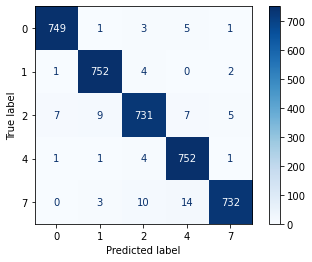

In [342]:
predictions = model128.predict(test_128, verbose=1)
p_class = np.argmax(predictions, axis=1)
cm = confusion_matrix(test_out, p_class)
# print(type(p_class))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("/home/urvashi/Downloads/Group_5/cm_128.png")
plt.show()

## 256 Dimension Representation

In [311]:
# Generating Three Layer FCNN Architecture
model256 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(256,), name='Input_Layer'),    
    tf.keras.layers.Dense(512, activation='sigmoid', name='Hidden_Layer_1'),
    tf.keras.layers.Dense(256, activation='sigmoid', name='Hidden_Layer_2'),
    tf.keras.layers.Dense(256, activation='sigmoid', name='Hidden_Layer_3'),
    tf.keras.layers.Dense(5, activation='softmax', name='Output_Layer')
])

# Printing the architecture details of the model
model256.summary()


Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (Dense)      (None, 512)               131584    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 256)               131328    
                                                                 
 Hidden_Layer_3 (Dense)      (None, 256)               65792     
                                                                 
 Output_Layer (Dense)        (None, 5)                 1285      
                                                                 
Total params: 329,989
Trainable params: 329,989
Non-trainable params: 0
_________________________________________________________________


In [312]:
#Setting the optimizer and compiling
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, name='Adam')
model256.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',    metrics=['accuracy'])

# Setting the convergence criteria and fitting the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,patience=2)
trained256 = model256.fit(train_256, train_out, epochs=10000, callbacks=callback)

Epoch 1/10000
356/356 [==============================] - 2s 3ms/step - loss: 0.2346 - accuracy: 0.9324
Epoch 2/10000
356/356 [==============================] - 1s 3ms/step - loss: 0.0706 - accuracy: 0.9790
Epoch 3/10000
356/356 [==============================] - 1s 3ms/step - loss: 0.0476 - accuracy: 0.9853
Epoch 4/10000
356/356 [==============================] - 1s 3ms/step - loss: 0.0365 - accuracy: 0.9894
Epoch 5/10000
356/356 [==============================] - 1s 3ms/step - loss: 0.0304 - accuracy: 0.9906
Epoch 6/10000
356/356 [==============================] - 1s 3ms/step - loss: 0.0204 - accuracy: 0.9943
Epoch 7/10000
356/356 [==============================] - 1s 3ms/step - loss: 0.0222 - accuracy: 0.9932
Epoch 8/10000
356/356 [==============================] - 1s 3ms/step - loss: 0.0178 - accuracy: 0.9952
Epoch 9/10000
356/356 [==============================] - 1s 3ms/step - loss: 0.0112 - accuracy: 0.9968
Epoch 10/10000
356/356 [==============================] - 1s 3ms/step - l

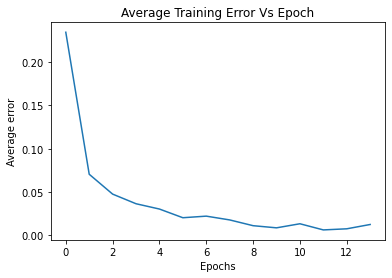

In [313]:
#Plotting error vs epoch graph
plt.plot(trained256.history['loss'])
plt.title("Average Training Error Vs Epoch")
plt.xlabel("Epochs")
plt.ylabel("Average error")
plt.savefig("/home/urvashi/Downloads/Group_5/model256.png")
plt.show()

In [314]:
loss, mse = model256.evaluate(val_256, val_out)

119/119 [==============================] - 0s 1ms/step - loss: 0.0787 - accuracy: 0.9810


In [315]:
loss, mse = model256.evaluate(test_256, val_out)

119/119 [==============================] - 0s 1ms/step - loss: 0.0954 - accuracy: 0.9773


119/119 [==============================] - 0s 1ms/step


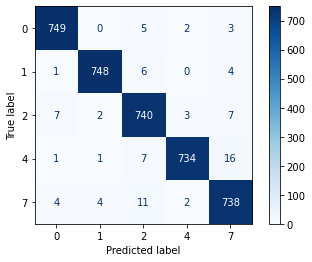

In [316]:
predictions = model256.predict(test_256, verbose=1)
p_class = np.argmax(predictions, axis=1)
cm = confusion_matrix(test_out, p_class)
# print(type(p_class))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("/home/urvashi/Downloads/Group_5/cm_256.png")
plt.show()

# Architecture 2

## 32 Dimension Representation

In [317]:
# Generating Three Layer FCNN Architecture
model32_a2 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32,), name='Input_Layer'),    
    tf.keras.layers.Dense(512, activation='sigmoid', name='Hidden_Layer_1'),
    tf.keras.layers.Dense(512, activation='sigmoid', name='Hidden_Layer_2'),
    tf.keras.layers.Dense(512, activation='sigmoid', name='Hidden_Layer_3'),
    tf.keras.layers.Dense(5, activation='softmax', name='Output_Layer')
])

# Printing the architecture details of the model
model32_a2.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (Dense)      (None, 512)               16896     
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               262656    
                                                                 
 Hidden_Layer_3 (Dense)      (None, 512)               262656    
                                                                 
 Output_Layer (Dense)        (None, 5)                 2565      
                                                                 
Total params: 544,773
Trainable params: 544,773
Non-trainable params: 0
_________________________________________________________________


In [318]:
#Setting the optimizer and compiling
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, name='Adam')
model32_a2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',    metrics=['accuracy'])

# Setting the convergence criteria and fitting the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,patience=2)
trained32_a2 = model32_a2.fit(train_32, train_out, epochs=10000, callbacks=callback)

Epoch 1/10000
356/356 [==============================] - 2s 4ms/step - loss: 0.2205 - accuracy: 0.9250
Epoch 2/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0818 - accuracy: 0.9754
Epoch 3/10000
356/356 [==============================] - 2s 4ms/step - loss: 0.0546 - accuracy: 0.9821
Epoch 4/10000
356/356 [==============================] - 2s 4ms/step - loss: 0.0440 - accuracy: 0.9854
Epoch 5/10000
356/356 [==============================] - 2s 4ms/step - loss: 0.0368 - accuracy: 0.9888
Epoch 6/10000
356/356 [==============================] - 2s 4ms/step - loss: 0.0279 - accuracy: 0.9911
Epoch 7/10000
356/356 [==============================] - 2s 4ms/step - loss: 0.0240 - accuracy: 0.9918
Epoch 8/10000
356/356 [==============================] - 2s 4ms/step - loss: 0.0228 - accuracy: 0.9932
Epoch 9/10000
356/356 [==============================] - 2s 4ms/step - loss: 0.0221 - accuracy: 0.9930
Epoch 10/10000
356/356 [==============================] - 2s 4ms/step - l

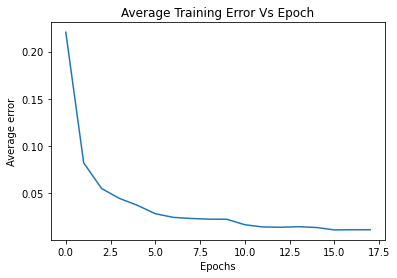

In [319]:
#Plotting error vs epoch graph
plt.plot(trained32_a2.history['loss'])
plt.title("Average Training Error Vs Epoch")
plt.xlabel("Epochs")
plt.ylabel("Average error")
plt.savefig("/home/urvashi/Downloads/Group_5/model_32_a2.png")
plt.show()

In [320]:
loss, mse = model32_a2.evaluate(val_32, val_out)

119/119 [==============================] - 0s 1ms/step - loss: 0.0634 - accuracy: 0.9826


In [321]:
loss, mse = model32_a2.evaluate(test_32, val_out)

119/119 [==============================] - 0s 1ms/step - loss: 0.0761 - accuracy: 0.9821


119/119 [==============================] - 0s 1ms/step


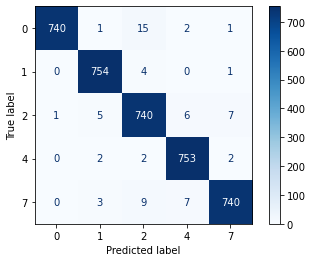

In [322]:
predictions = model32_a2.predict(test_32, verbose=1)
p_class = np.argmax(predictions, axis=1)
cm = confusion_matrix(test_out, p_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("/home/urvashi/Downloads/Group_5/cm_32_a2.png")
plt.show()

## 64 Dimension Representation

In [323]:
# Generating Three Layer FCNN Architecture
model64_a2 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(64,), name='Input_Layer'),    
    tf.keras.layers.Dense(512, activation='sigmoid', name='Hidden_Layer_1'),
    tf.keras.layers.Dense(512, activation='sigmoid', name='Hidden_Layer_2'),
    tf.keras.layers.Dense(512, activation='sigmoid', name='Hidden_Layer_3'),
    tf.keras.layers.Dense(5, activation='softmax', name='Output_Layer')
])

# Printing the architecture details of the model
model64_a2.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (Dense)      (None, 512)               33280     
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               262656    
                                                                 
 Hidden_Layer_3 (Dense)      (None, 512)               262656    
                                                                 
 Output_Layer (Dense)        (None, 5)                 2565      
                                                                 
Total params: 561,157
Trainable params: 561,157
Non-trainable params: 0
_________________________________________________________________


In [324]:
#Setting the optimizer and compiling
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, name='Adam')
model64_a2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',    metrics=['accuracy'])

# Setting the convergence criteria and fitting the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,patience=2)
trained64_a2 = model64_a2.fit(train_64, train_out, epochs=10000, callbacks=callback)

Epoch 1/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.2039 - accuracy: 0.9364
Epoch 2/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0740 - accuracy: 0.9777
Epoch 3/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0573 - accuracy: 0.9816
Epoch 4/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0440 - accuracy: 0.9856
Epoch 5/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0353 - accuracy: 0.9880
Epoch 6/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0280 - accuracy: 0.9900
Epoch 7/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0213 - accuracy: 0.9935
Epoch 8/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0185 - accuracy: 0.9941
Epoch 9/10000
356/356 [==============================] - 2s 4ms/step - loss: 0.0123 - accuracy: 0.9965
Epoch 10/10000
356/356 [==============================] - 2s 4ms/step - l

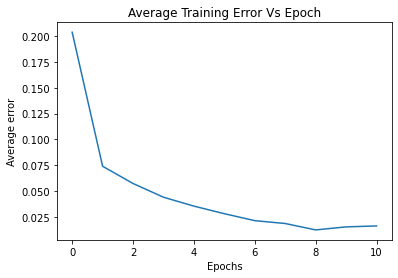

In [325]:
#Plotting error vs epoch graph
plt.plot(trained64_a2.history['loss'])
plt.title("Average Training Error Vs Epoch")
plt.xlabel("Epochs")
plt.ylabel("Average error")
plt.savefig("/home/urvashi/Downloads/Group_5/model64_a2.png")
plt.show()

In [326]:
loss, mse = model64_a2.evaluate(val_64, val_out)

119/119 [==============================] - 0s 1ms/step - loss: 0.0682 - accuracy: 0.9818


In [327]:
loss, mse = model64_a2.evaluate(val_64, val_out)

119/119 [==============================] - 0s 1ms/step - loss: 0.0682 - accuracy: 0.9818


119/119 [==============================] - 0s 1ms/step


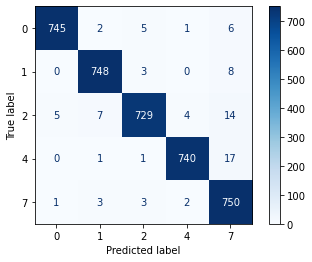

In [328]:
predictions = model64_a2.predict(test_64, verbose=1)
p_class = np.argmax(predictions, axis=1)
cm = confusion_matrix(test_out, p_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("/home/urvashi/Downloads/Group_5/cm_64_a2.png")
plt.show()

## 128 Dimension Representation

In [329]:
# Generating Three Layer FCNN Architecture
model128_a2 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(128,), name='Input_Layer'),    
    tf.keras.layers.Dense(512, activation='sigmoid', name='Hidden_Layer_1'),
    tf.keras.layers.Dense(512, activation='sigmoid', name='Hidden_Layer_2'),
    tf.keras.layers.Dense(512, activation='sigmoid', name='Hidden_Layer_3'),
    tf.keras.layers.Dense(5, activation='softmax', name='Output_Layer')
])

# Printing the architecture details of the model
model128_a2.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (Dense)      (None, 512)               66048     
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               262656    
                                                                 
 Hidden_Layer_3 (Dense)      (None, 512)               262656    
                                                                 
 Output_Layer (Dense)        (None, 5)                 2565      
                                                                 
Total params: 593,925
Trainable params: 593,925
Non-trainable params: 0
_________________________________________________________________


In [330]:
#Setting the optimizer and compiling
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, name='Adam')
model128_a2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',    metrics=['accuracy'])

# Setting the convergence criteria and fitting the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,patience=1)
trained128_a2 = model128_a2.fit(train_128, train_out, epochs=10000, callbacks=callback)

Epoch 1/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.2162 - accuracy: 0.9339
Epoch 2/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0705 - accuracy: 0.9780
Epoch 3/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0539 - accuracy: 0.9838
Epoch 4/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0430 - accuracy: 0.9860
Epoch 5/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0301 - accuracy: 0.9903
Epoch 6/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0299 - accuracy: 0.9902
Epoch 7/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0218 - accuracy: 0.9927
Epoch 8/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0163 - accuracy: 0.9953
Epoch 9/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0139 - accuracy: 0.9952
Epoch 10/10000
356/356 [==============================] - 2s 5ms/step - l

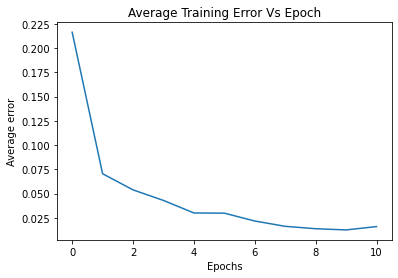

In [343]:
#Plotting error vs epoch graph
plt.plot(trained128_a2.history['loss'])
plt.title("Average Training Error Vs Epoch")
plt.xlabel("Epochs")
plt.ylabel("Average error")
plt.savefig("/home/urvashi/Downloads/Group_5/model128_a2.png")
plt.show()

In [332]:
loss, mse = model128_a2.evaluate(val_128, val_out)

119/119 [==============================] - 0s 1ms/step - loss: 0.0851 - accuracy: 0.9781


In [333]:
loss, mse = model128_a2.evaluate(test_128, val_out)

119/119 [==============================] - 0s 1ms/step - loss: 0.1079 - accuracy: 0.9771


119/119 [==============================] - 0s 1ms/step


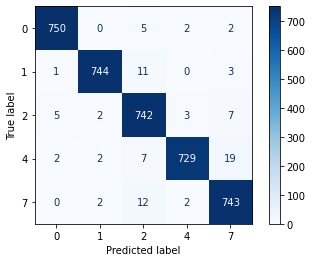

In [341]:
predictions = model128_a2.predict(test_128, verbose=1)
p_class = np.argmax(predictions, axis=1)
cm = confusion_matrix(test_out, p_class)
# print(type(p_class))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("/home/urvashi/Downloads/Group_5/cm_128_a2.png")
plt.show()

## 256 Dimension Representation

In [335]:
# Generating Three Layer FCNN Architecture
model256_a2 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(256,), name='Input_Layer'),    
    tf.keras.layers.Dense(512, activation='sigmoid', name='Hidden_Layer_1'),
    tf.keras.layers.Dense(512, activation='sigmoid', name='Hidden_Layer_2'),
    tf.keras.layers.Dense(512, activation='sigmoid', name='Hidden_Layer_3'),
    tf.keras.layers.Dense(5, activation='softmax', name='Output_Layer')
])

# Printing the architecture details of the model
model256_a2.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (Dense)      (None, 512)               131584    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               262656    
                                                                 
 Hidden_Layer_3 (Dense)      (None, 512)               262656    
                                                                 
 Output_Layer (Dense)        (None, 5)                 2565      
                                                                 
Total params: 659,461
Trainable params: 659,461
Non-trainable params: 0
_________________________________________________________________


In [336]:
#Setting the optimizer and compiling
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, name='Adam')
model256_a2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',    metrics=['accuracy'])

# Setting the convergence criteria and fitting the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,patience=1)
trained256_a2 = model256_a2.fit(train_256, train_out, epochs=10000, callbacks=callback)

Epoch 1/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.2181 - accuracy: 0.9308
Epoch 2/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0751 - accuracy: 0.9765
Epoch 3/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0528 - accuracy: 0.9835
Epoch 4/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0355 - accuracy: 0.9890
Epoch 5/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0308 - accuracy: 0.9883
Epoch 6/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0277 - accuracy: 0.9910
Epoch 7/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0240 - accuracy: 0.9917
Epoch 8/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0191 - accuracy: 0.9940
Epoch 9/10000
356/356 [==============================] - 2s 5ms/step - loss: 0.0095 - accuracy: 0.9971
Epoch 10/10000
356/356 [==============================] - 2s 5ms/step - l

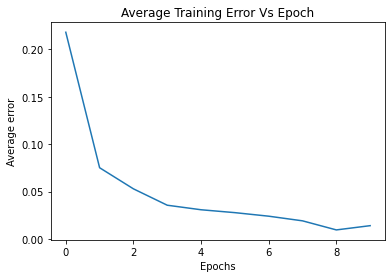

In [337]:
#Plotting error vs epoch graph
plt.plot(trained256_a2.history['loss'])
plt.title("Average Training Error Vs Epoch")
plt.xlabel("Epochs")
plt.ylabel("Average error")
plt.savefig("/home/urvashi/Downloads/Group_5/model256_a2.png")
plt.show()

In [338]:
loss, mse = model256_a2.evaluate(val_256, val_out)

119/119 [==============================] - 0s 2ms/step - loss: 0.0888 - accuracy: 0.9765


In [339]:
loss, mse = model256_a2.evaluate(test_256, val_out)

119/119 [==============================] - 0s 1ms/step - loss: 0.1211 - accuracy: 0.9708


119/119 [==============================] - 0s 1ms/step


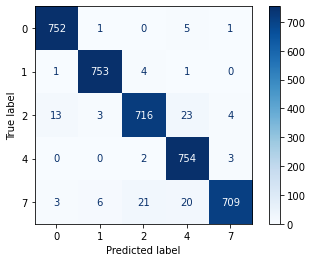

In [340]:
predictions = model256_a2.predict(test_256, verbose=1)
p_class = np.argmax(predictions, axis=1)
cm = confusion_matrix(test_out, p_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("/home/urvashi/Downloads/Group_5/cm_256_a2.png")
plt.show()